In [14]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import os
import pandas as pd
import re
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from matplotlib.colors import LinearSegmentedColormap



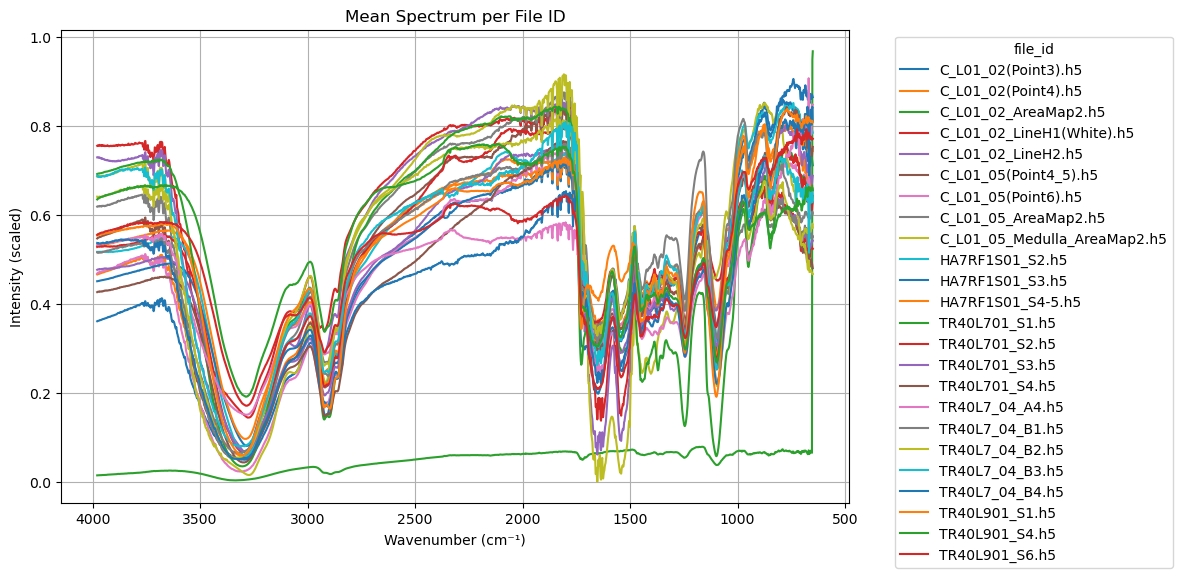

In [7]:
# === 1. Load and plot all spectra ===
file_path = 'spectra_scaled.csv'
df = pd.read_csv(file_path, low_memory=False)

# Extract spectral columns
spectral_columns = [col for col in df.columns if col.replace('.', '', 1).isdigit()]
spectral_data = df[spectral_columns].apply(pd.to_numeric, errors='coerce')

# Plot mean spectra per unique file_id
plt.figure(figsize=(12, 6))
for file_id in df['file_id'].unique():
    subset = df[df['file_id'] == file_id]
    mean_spectrum = subset[spectral_columns].apply(pd.to_numeric, errors='coerce').mean()
    plt.plot([float(w) for w in spectral_columns], mean_spectrum, label=file_id)
plt.title("Mean Spectrum per File ID")
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("Intensity (scaled)")
plt.gca().invert_xaxis()
plt.legend(title='file_id', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# === 2. Filter spectra with strong keratin double peaks (~1650 and 1540 cm⁻¹) ===
spectral_wavenumbers = [float(w) for w in spectral_columns]
closest_1650 = min(spectral_wavenumbers, key=lambda x: abs(x - 1650))
closest_1540 = min(spectral_wavenumbers, key=lambda x: abs(x - 1540))
keratin_cols = [str(closest_1650), str(closest_1540)]
df[keratin_cols[0]] = pd.to_numeric(df[keratin_cols[0]], errors='coerce')
df[keratin_cols[1]] = pd.to_numeric(df[keratin_cols[1]], errors='coerce')
keratin_strength = df[keratin_cols].mean(axis=1)
keratin_threshold = np.percentile(keratin_strength, 75)
df_keratin = df[keratin_strength > keratin_threshold]

In [10]:

# === 3. Further filter for strong 1730 C=O peak (potential cocaine marker) ===
closest_1730 = min(spectral_wavenumbers, key=lambda x: abs(x - 1730))
col_1730 = str(closest_1730)
df_keratin[col_1730] = pd.to_numeric(df_keratin[col_1730], errors='coerce')
threshold_1730 = np.percentile(df_keratin[col_1730], 90)
df_strong = df_keratin[df_keratin[col_1730] > threshold_1730]

# Normalize likelihood based on 1730 peak
df_strong['cocaine_likelihood'] = (
    (df_strong[col_1730] - df_strong[col_1730].min()) /
    (df_strong[col_1730].max() - df_strong[col_1730].min())
)

C:\Users\tssan\AppData\Local\Temp\ipykernel_29356\722709602.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keratin[col_1730] = pd.to_numeric(df_keratin[col_1730], errors='coerce')
C:\Users\tssan\AppData\Local\Temp\ipykernel_29356\722709602.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strong['cocaine_likelihood'] = (


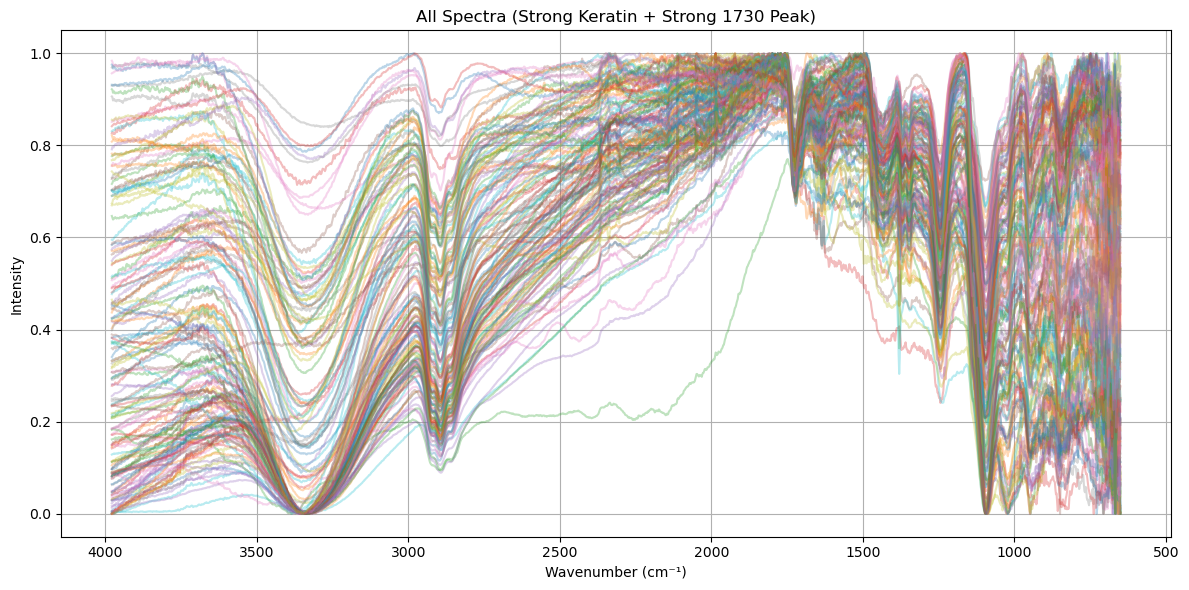

In [11]:

# === 4. Plot all spectra (no mean) and cluster into 5 groups ===
plt.figure(figsize=(12, 6))
for _, row in df_strong.iterrows():
    plt.plot([float(w) for w in spectral_columns], row[spectral_columns].astype(float), alpha=0.3)
plt.title("All Spectra (Strong Keratin + Strong 1730 Peak)")
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("Intensity")
plt.gca().invert_xaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


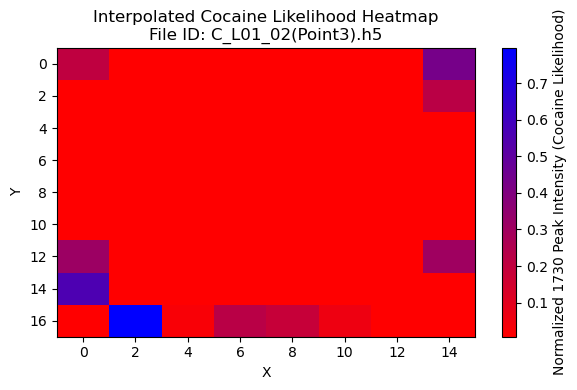

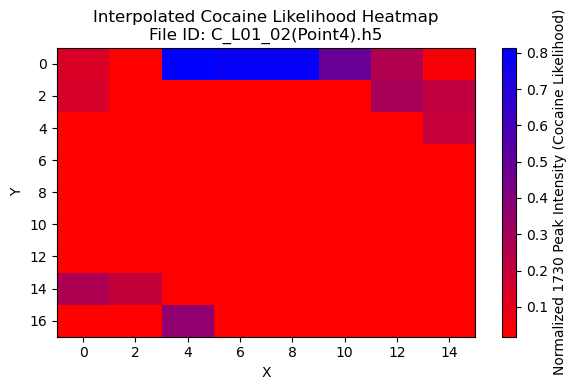

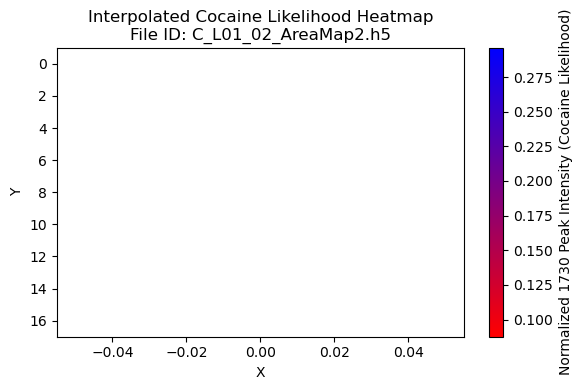

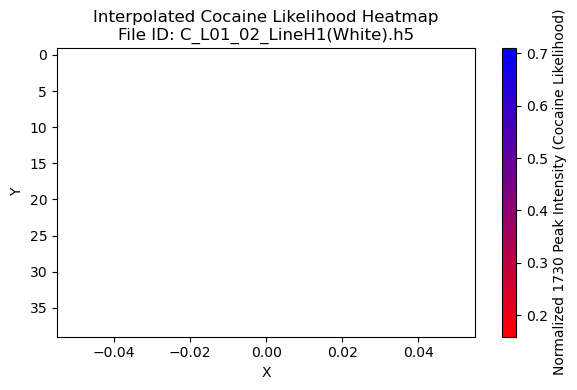

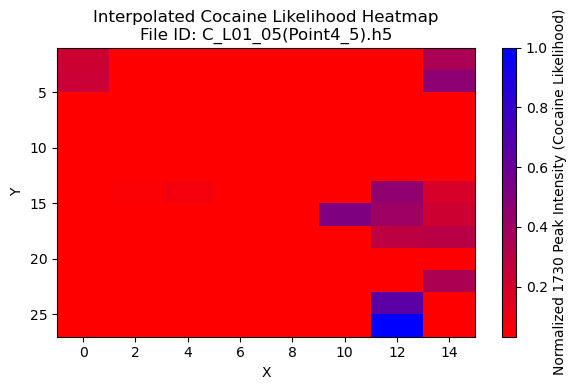

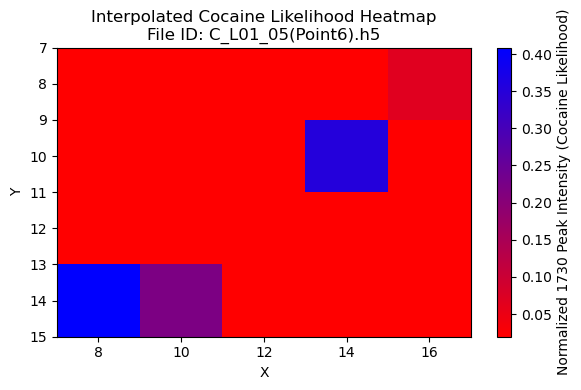

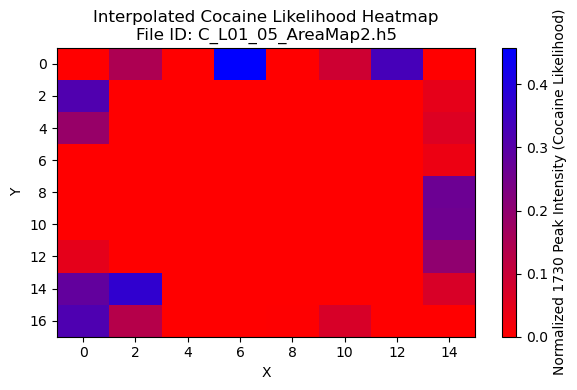

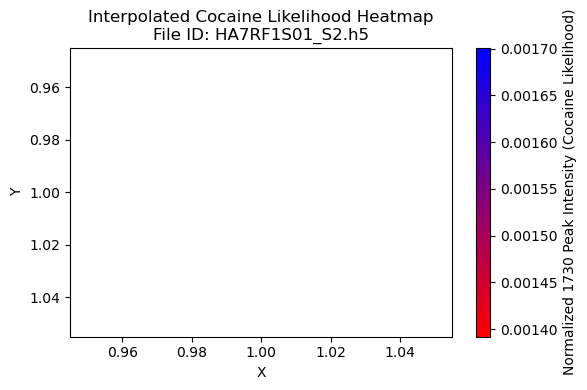

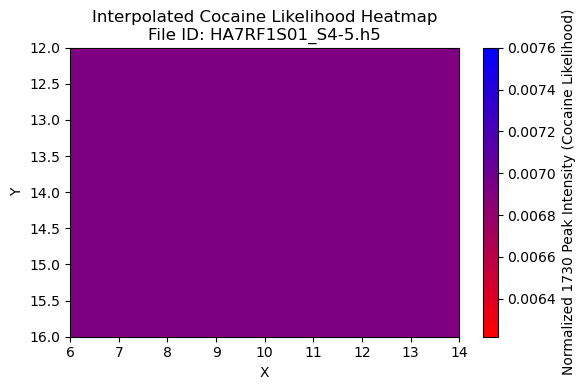

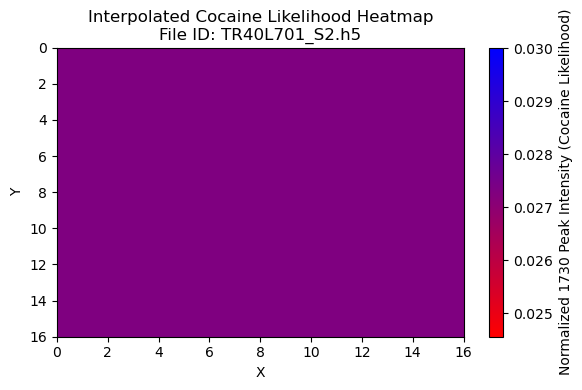

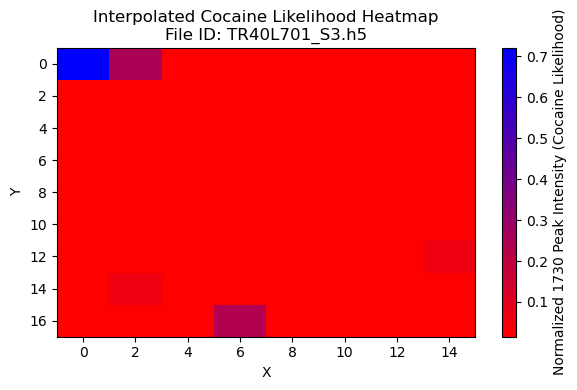

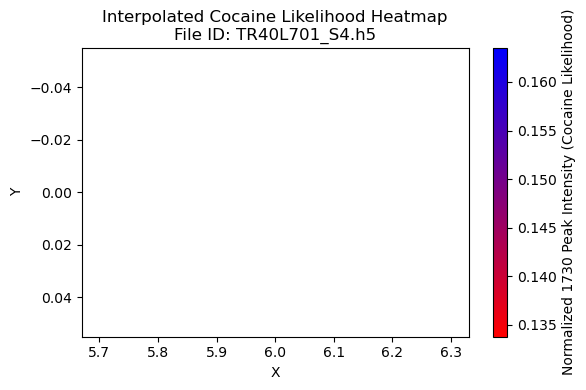

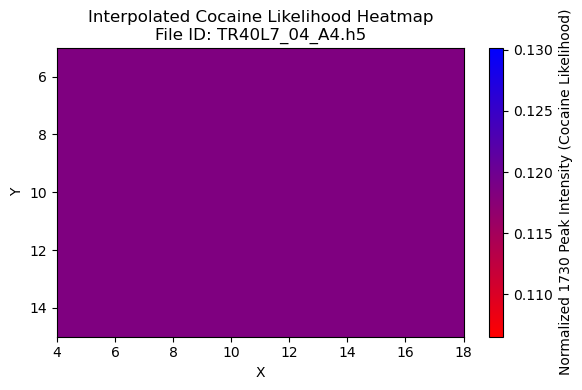

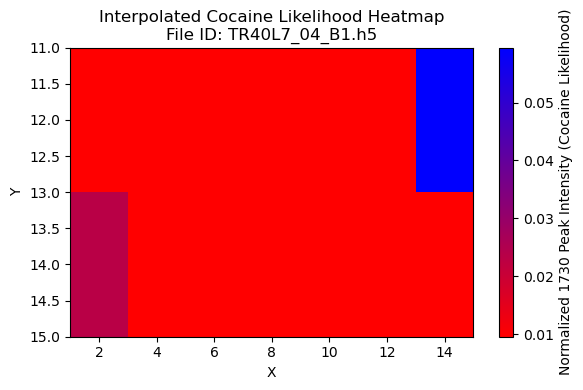

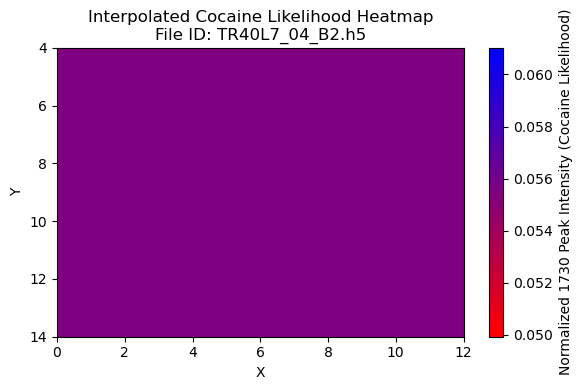

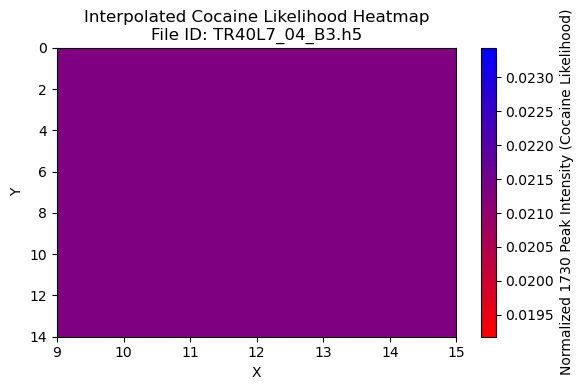

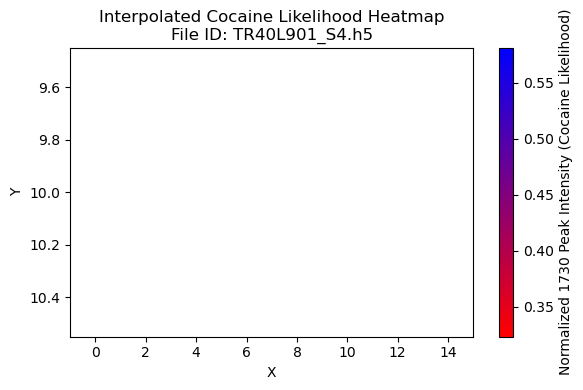

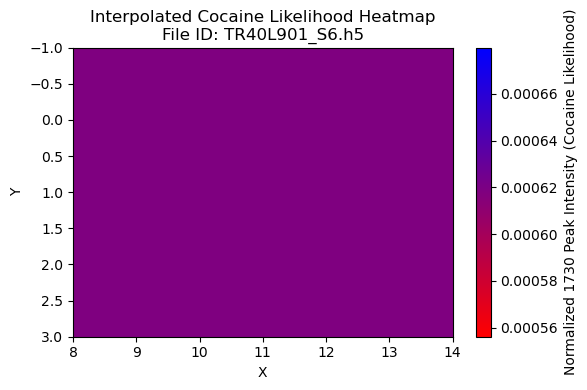

In [15]:

# === 5. Spatial heatmaps per file_id (interpolated, colormap red to blue) ===
# Custom red-to-blue colormap
red_blue_cmap = LinearSegmentedColormap.from_list("red_blue", ["red", "blue"])
grid_spacing = 2  # coarse resolution to reduce memory use

for file_id in df_strong['file_id'].unique():
    subset = df_strong[df_strong['file_id'] == file_id]

    x = subset['x'].astype(int)
    y = subset['y'].astype(int)
    likelihood = subset['cocaine_likelihood']

    x_range = range(x.min(), x.max() + 1, grid_spacing)
    y_range = range(y.min(), y.max() + 1, grid_spacing)
    heatmap = pd.DataFrame(
        np.full((len(y_range), len(x_range)), fill_value=likelihood.min()),
        index=y_range, columns=x_range
    )

    for xi, yi, li in zip(x, y, likelihood):
        gx, gy = xi - xi % grid_spacing, yi - yi % grid_spacing
        if gy in heatmap.index and gx in heatmap.columns:
            heatmap.at[gy, gx] = max(heatmap.at[gy, gx], li)

    plt.figure(figsize=(6, 4))
    hm = plt.pcolormesh(
        heatmap.columns, heatmap.index, heatmap.values,
        shading='auto', cmap=red_blue_cmap
    )
    plt.colorbar(hm, label="Normalized 1730 Peak Intensity (Cocaine Likelihood)")
    plt.title(f"Interpolated Cocaine Likelihood Heatmap\nFile ID: {file_id}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().invert_yaxis()
    plt.grid(False)
    plt.tight_layout()
    plt.show()
